In [8]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg")
data["is_old"] = data.is_old.astype(int)
data = (data.drop(index=data[data.population < 5].index).dropna().reset_index())

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y, "group": data.group})
grouped = xy.groupby("group").mean()

d = distance_matrix(grouped, grouped)
P_norm = StandardScaler().fit_transform(data.lutheran_ln.values.reshape(-1, 1)).flatten()
O_norm = StandardScaler().fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1)).flatten()

N = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())
assert N_CLUSTERS, N_CLUSTERS == d.shape

In [9]:
data.explore(
    column="lutheran",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [10]:
data.explore(
    column="orthodox_proportion",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [11]:
with pm.Model() as model_1:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)
    F = pm.MutableData("F", data.is_old)

    θ = pm.Normal("θ", [0, 0, 0], [0.1, 0.1, 0.1], shape=3)

    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1, 0.1])), shape=(N_CLUSTERS, 3)
    )

    μ = β[idx, 0] + β[idx, 1] * W + β[idx, 2] * F
    σ_O = pm.HalfNormal("σ_O", 0.1)
    O = pm.Normal("O", mu=μ, sigma=σ_O, observed=O_norm)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True, target_accept=0.95)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Sampling: [O, β, θ, σ_O]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, β, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 737 seconds.
Sampling: [O]


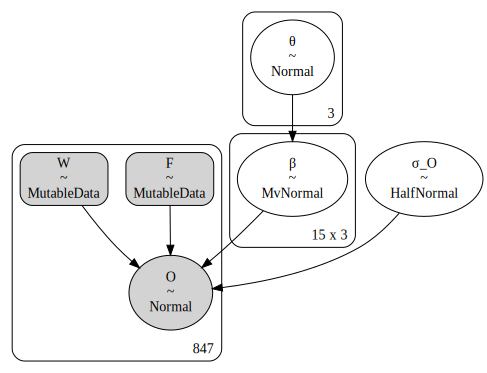

In [12]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['chol_cov_corr'] have not been found and will be ignored
  warnings.warn(


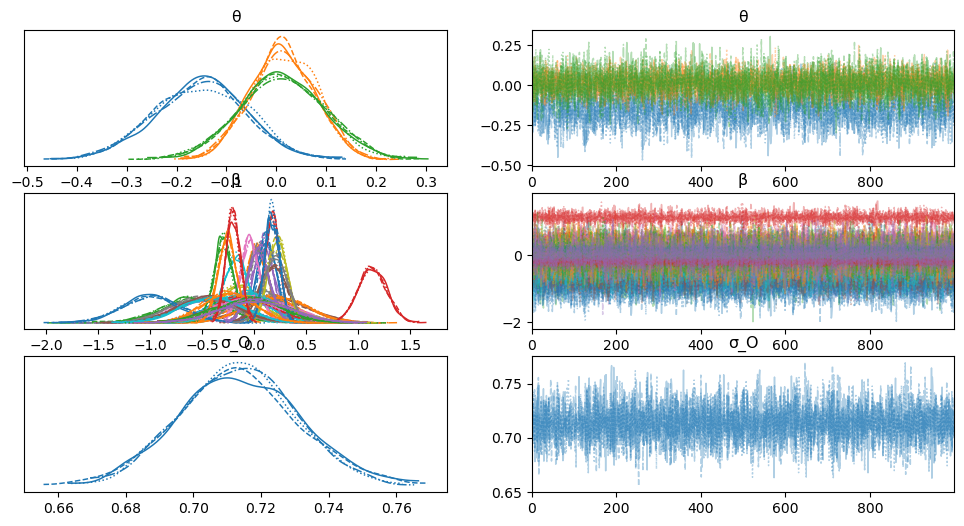

In [13]:
# az.plot_posterior(posterior_1)
az.plot_trace(posterior_1, var_names=["~chol_cov_corr"])
plt.show()

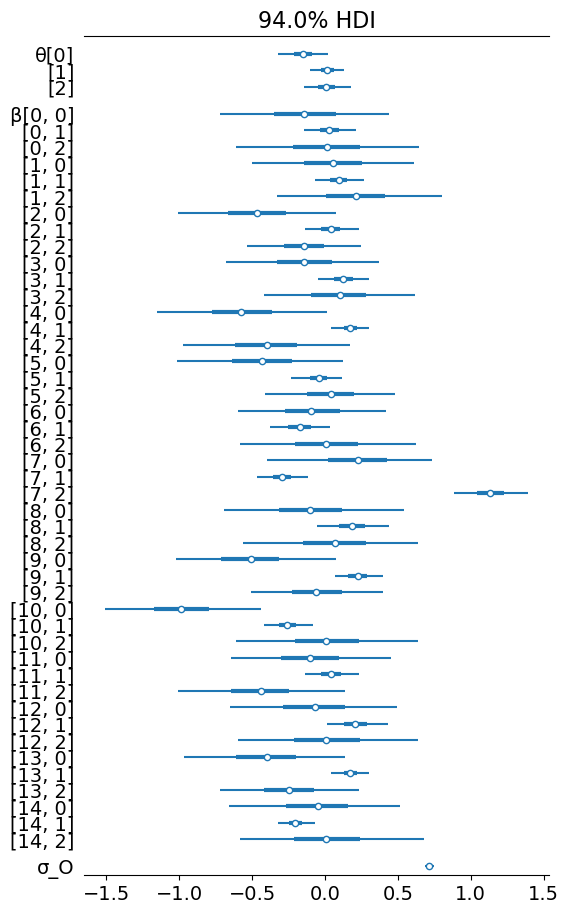

In [14]:
az.plot_forest(posterior_1, combined=True, hdi_prob=0.94)
plt.show()

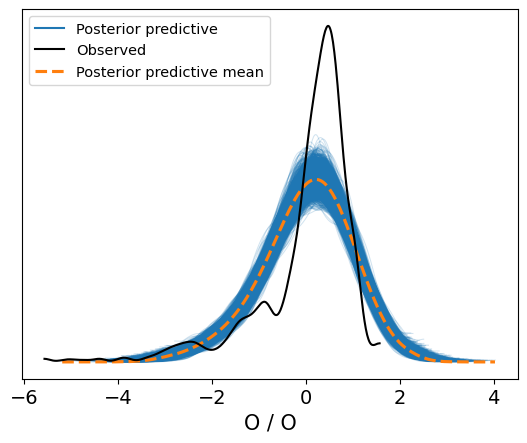

In [15]:
az.plot_ppc(posterior_prediction_1)
plt.show()

# Clustering

In [16]:
cluster_colors = plt.get_cmap("tab20")
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

<AxesSubplot: xlabel='total_income_ln', ylabel='orthodox_proportion'>

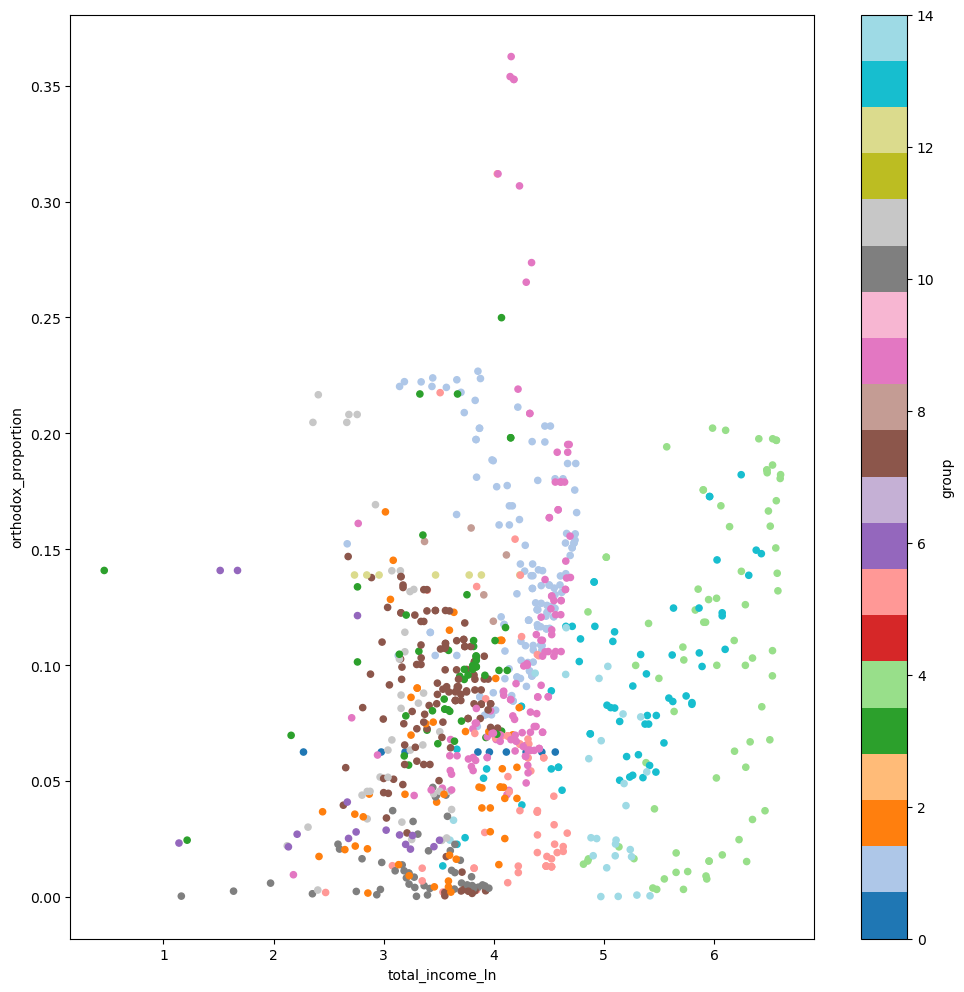

In [17]:
data.plot(
    kind='scatter', x='total_income_ln', y='orthodox_proportion', c='group', cmap='tab20', figsize=(12, 12),
)
# for i in sorted(data.group.unique()):
    # data.loc[data.group == i, :].plot(kind='scatter', x='total_income_ln', y='orthodox_proportion')
    # plt.title(i)
    # plt.show()

# Final model with 12 geographical clusters (K-means)

$$ P_i \sim N(μ_{P,i}, σ_P), i = 0, 1, ... 846 $$
$$ O_i \sim N(μ_{O,i}, σ_O), i = 0, 1, ... 846 $$
$$ mi_{P,i} = [1 \; W]  β_{P,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ μ_{O,i} = [1 \; W]  β_{O,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ σ_P \sim Exp(1) $$
$$ σ_O \sim Exp(1) $$
$$ β_{P,k} \sim MvNormal \left( θ_P, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ β_{O,k} \sim MvNormal \left( θ_O, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ θ_{P} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ θ_{O} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
where W is Component 3, i indicates the cadastral plot, and k[i] the cluster of the cadastral plot

In [18]:
with pm.Model() as model_2:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)
    F = pm.MutableData("F", data.is_old)

    θ = pm.Normal("θ", [0, 0, 0], [0.5, 0.5, 0.5], shape=3)
    chol, ρ, σ_β = pm.LKJCholeskyCov("chol_cov", n=3, eta=5, sd_dist=pm.HalfNormal.dist(0.5), compute_corr=True)

    β = pm.MvNormal(
        "β", mu=θ, chol=chol, shape=(N_CLUSTERS, 3)
    )

    μ = β[idx, 0] + β[idx, 1] * W + β[idx, 2] * F

    # η2 = pm.HalfStudentT('η²', 1, 10)
    # ρ2 = pm.HalfStudentT('ρ²', 1, 10)

    # K = η2 * (at.exp(-ρ2 * np.power(d, 2) ** 2) + np.diag([0.01] * N_CLUSTERS))
    
    # γ_O = pm.MvNormal("γ_O", mu=np.zeros(N), cov=K, shape=N)

    σ_O = pm.HalfNormal("σ_O", 0.1)

    O = pm.Normal("O", mu=μ, sigma=σ_O, observed=O_norm)

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.95,
        random_seed=SEED,
    )
    posterior_prediction_2 = pm.sample_posterior_predictive(
        posterior_2, 
        random_seed=SEED,
    )

Sampling: [O, chol_cov, β, θ, σ_O]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, chol_cov, β, σ_O]


ValueError: Not enough samples to build a trace.

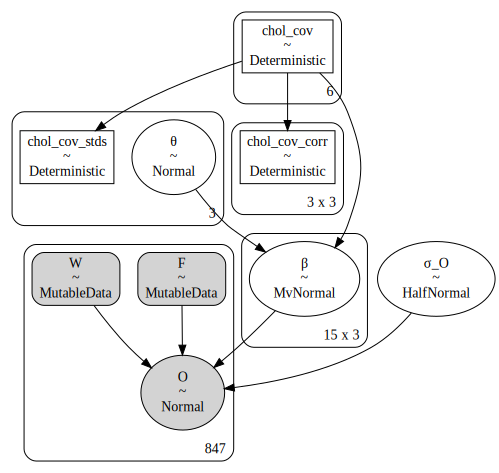

In [ ]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

## Prior predictive check

In [ ]:
# prior = prior_2["prior"]
# x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
# y = prior["β_P"][:, :, 0, 0] + prior["β_P"][:, :, 0, 1] * x
# _, ax = plt.subplots()
# ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
# ax.set_xlabel("W")
# ax.set_ylabel("μ_P")

In [ ]:
# x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
# y = prior["β_O"][:, :, 0, 0] + prior["β_O"][:, :, 0, 1] * x
# _, ax = plt.subplots()
# ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
# ax.set_xlabel("W")
# ax.set_ylabel("μ_O")

## Posterior predictive check

<AxesSubplot: xlabel='O / O'>

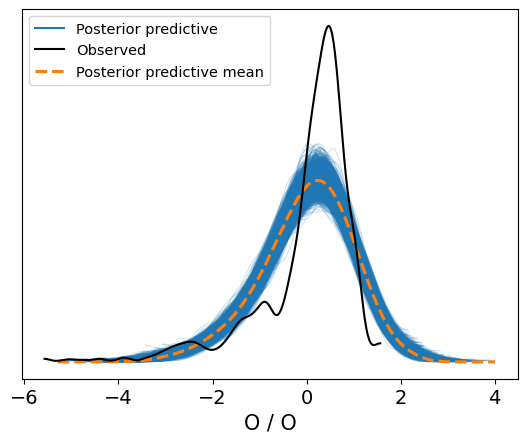

In [ ]:
az.plot_ppc(posterior_prediction_2)

## Trace plots

In [ ]:
az.summary(posterior_2, hdi_prob=0.95)

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
θ[0]                -0.468  0.319    -1.091      0.147      0.006    0.004   
θ[1]                 0.076  0.103    -0.121      0.287      0.002    0.001   
θ[2]                -0.044  0.280    -0.594      0.499      0.005    0.004   
β[0, 0]             -0.226  0.833    -1.853      1.338      0.015    0.012   
β[0, 1]              0.054  0.220    -0.356      0.486      0.004    0.003   
...                    ...    ...       ...        ...        ...      ...   
chol_cov_corr[2, 1] -0.325  0.208    -0.696      0.099      0.004    0.003   
chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000      0.000    0.000   
chol_cov_stds[0]     1.260  0.218     0.865      1.699      0.005    0.004   
chol_cov_stds[1]     0.372  0.070     0.244      0.513      0.002    0.001   
chol_cov_stds[2]     0.858  0.228     0.459      1.314      0.007    0.005   

                     ess_bulk  ess_tail  r_hat  
θ[0]                   2556.0    3369.0    1.0  
θ[1]                   2622.0    2760.0    1.0  
θ[2]                   3087.0    3146.0    1.0  
β[0, 0]                3073.0    2603.0    1.0  
β[0, 1]                3042.0    2431.0    1.0  
...                       ...       ...    ...  
chol_cov_corr[2, 1]    2644.0    3309.0    1.0  
chol_cov_corr[2, 2]    3989.0    3850.0    1.0  
chol_cov_stds[0]       1597.0    2664.0    1.0  
chol_cov_stds[1]       1681.0    2322.0    1.0  
chol_cov_stds[2]       1203.0    2380.0    1.0  

[67 rows x 9 columns]

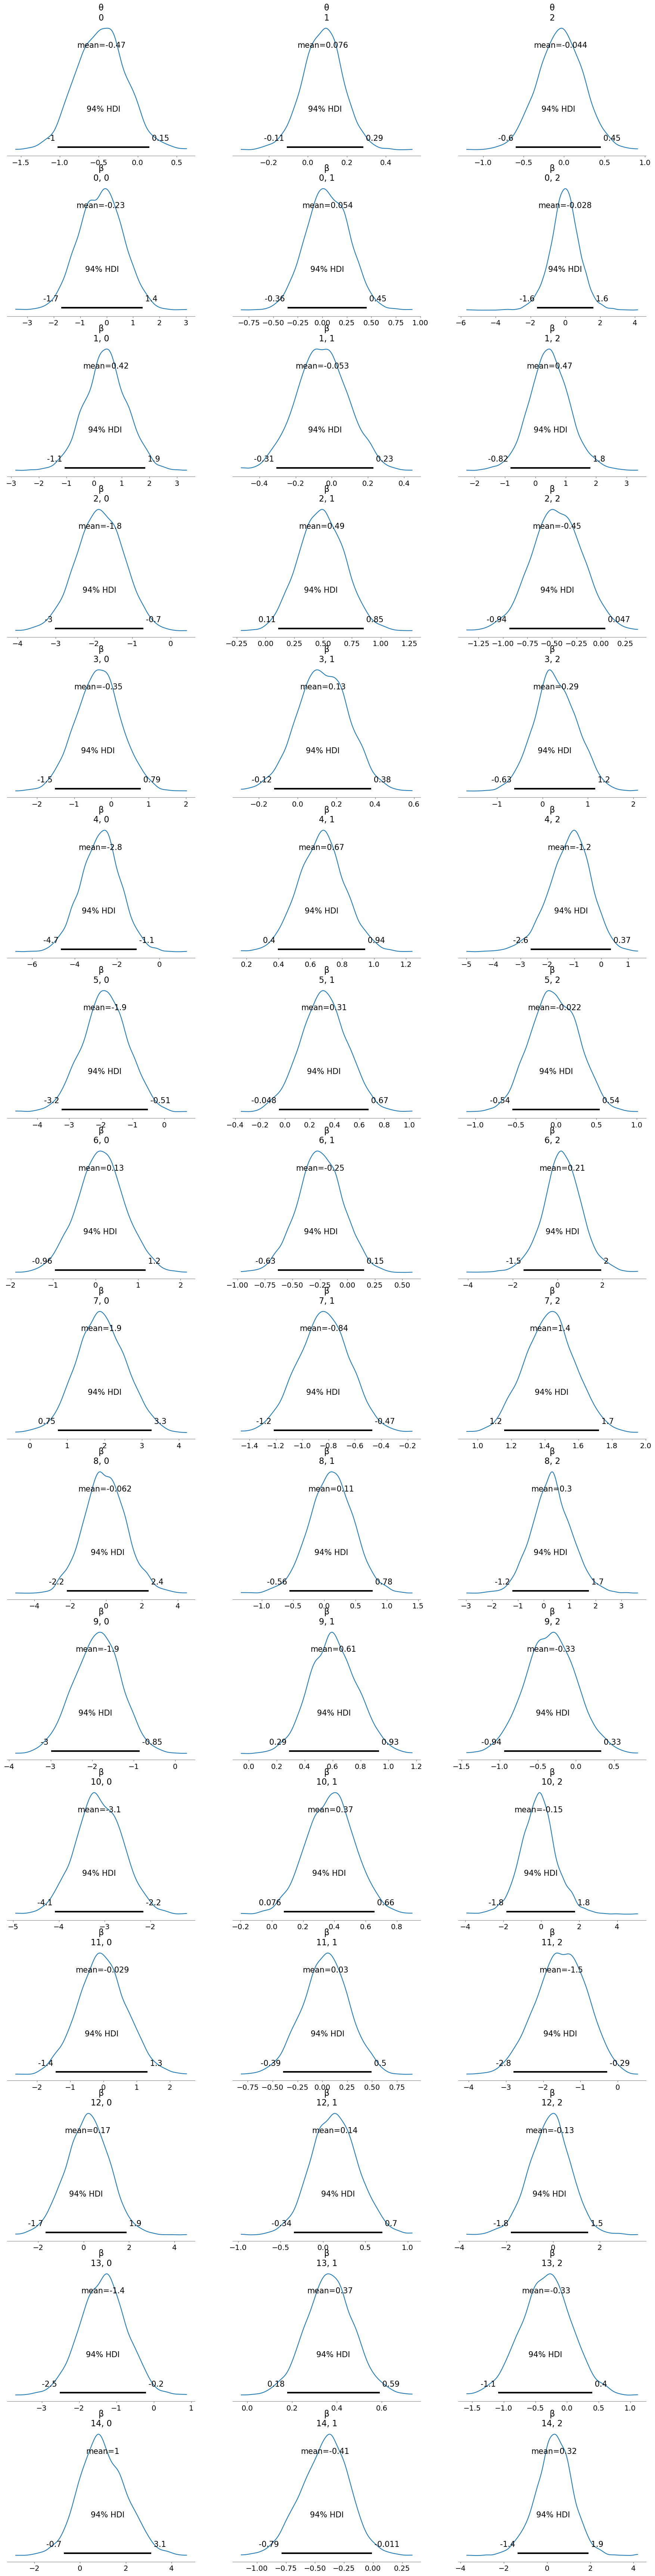

In [ ]:
with az.rc_context({"plot.max_subplots": 48}):  
    az.plot_posterior(posterior_2, var_names=["θ", "β"], grid=[N_CLUSTERS + 1, 3])
plt.show()

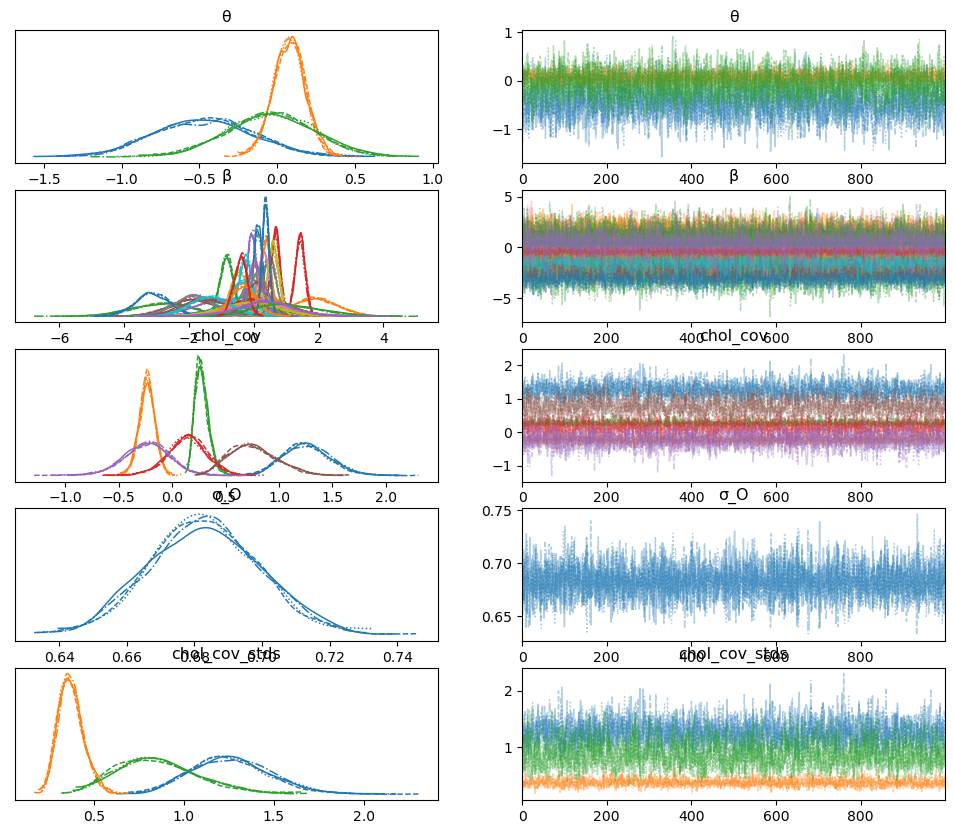

In [ ]:
az.plot_trace(posterior_2, var_names="~chol_cov_corr")
plt.show()

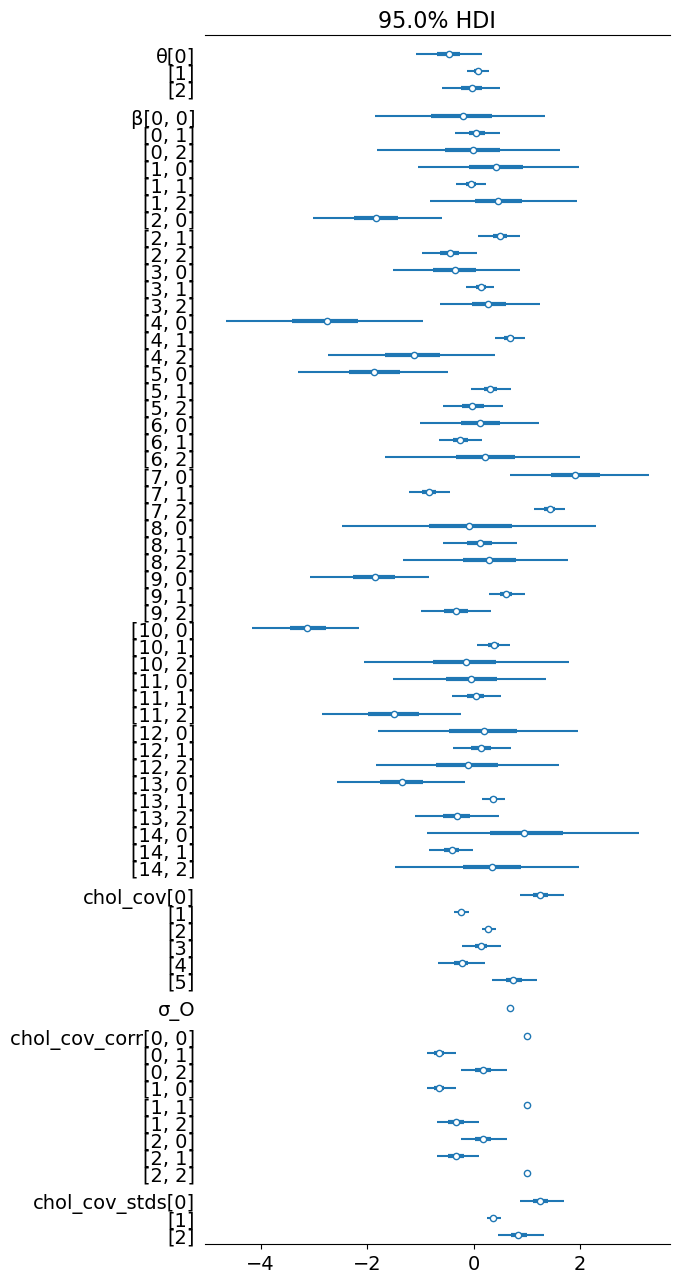

In [ ]:
az.plot_forest(posterior_2, combined=True, hdi_prob=0.95)
plt.show()